In [2]:
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=e5ce2996665a044ba33a33a5731494401ce15fbbadee4bedd7bff1f9c2e31029
  Stored in directory: /root/.cache/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
Successfully built afinn


In [3]:
# Importing required libraries

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pylab as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 15})

# Text Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from afinn import Afinn
from collections import Counter

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Model Validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [4]:
#Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

#Model Accuracy
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report

# To save & load models
from pickle import dump
from pickle import load

#Warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Custom Function to divide the rating into two class problem (howevere it is is primitive technique)
def map_sentiment(rating):
    if rating <= 2:
        return 0
    else:
        return 1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/MyDrive/hotel_reviews.xlsx')
df

Mounted at /content/drive


Review  Rating
0      nice hotel expensive parking got good deal sta...     4.0
1      ok nothing special charge diamond member hilto...     2.0
2      nice rooms not 4* experience hotel monaco seat...     3.0
3      unique, great stay, wonderful time hotel monac...     5.0
4      great stay great stay, went seahawk game aweso...     5.0
...                                                  ...     ...
20486  best kept secret 3rd time staying charm, not 5...     5.0
20487  great location price view hotel great quick pl...     4.0
20488  ok just looks nice modern outside, desk staff ...     2.0
20489  hotel theft ruined vacation hotel opened sept ...     1.0
20490  people talking, ca n't believe excellent ratin...     2.0

[20491 rows x 2 columns]

In [7]:
# sentiment maped into 2 class 1=Positive reviews 0=Negtaive reviews
df['Sentiment'] = [map_sentiment(x) for x in df['Rating']]
df.head()

Review  Rating  Sentiment
0  nice hotel expensive parking got good deal sta...     4.0          1
1  ok nothing special charge diamond member hilto...     2.0          0
2  nice rooms not 4* experience hotel monaco seat...     3.0          1
3  unique, great stay, wonderful time hotel monac...     5.0          1
4  great stay great stay, went seahawk game aweso...     5.0          1

In [8]:
# no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Review     20491 non-null  object 
 1   Rating     20491 non-null  float64
 2   Sentiment  20491 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 480.4+ KB


In [9]:
# No Duplicate values
df.duplicated().value_counts()

False    20491
dtype: int64

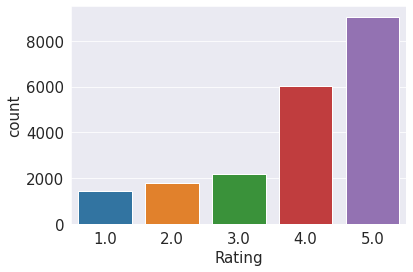

In [10]:
# Most of the rating are in 4 and 5 
sns.countplot(df['Rating'])

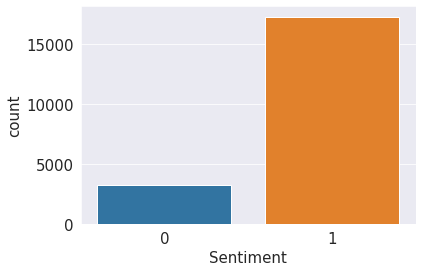

In [11]:
# 1 = Positive 0 = Negative
sns.countplot(df['Sentiment'])

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
#Lemmatization
wordnet=WordNetLemmatizer()

#Stop word
stop_words=stopwords.words('english')

nlp=spacy.load('en_core_web_sm')

In [14]:
# Varibale created for words which are not included in the stopwords
not_stopwords = ("aren", "aren't", "couldn", "couldn't", "didn", "didn't",
                 "doesn", "doesn't", "don", "don't", "hadn", "hadn't", "hasn",
                 "hasn't", "haven", "haven't", "isn", "isn't", "mustn",
                 "mustn't", "no", "not", "only", "shouldn", "shouldn't",
                 "should've", "wasn", "wasn't", "weren", "weren't", "will",
                 "wouldn", "wouldn't", "won't", "very")
stop_words_ = [words for words in stop_words if words not in not_stopwords]

# Additional words added in the stop word list
stop_words_.append("I")
stop_words_.append("the")
stop_words_.append("s")
print(stop_words_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can'

In [15]:
corpus = []
for i in range(0, len(df)):
    # Removal of puntuations
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])

    # Converting Text to Lower case
    review = review.lower()

    # Spliting each words - eg ['I','was','happy']
    review = review.split()

    # Applying Lemmitization for the words eg: Argument -> Argue - Using Spacy Library
    review = nlp(' '.join(review))
    review = [token.lemma_ for token in review]

    # Removal of stop words
    review = [word for word in review if word not in stop_words_]

    # Joining the words in sentences
    review = ' '.join(review)
    corpus.append(review)

In [16]:
# cleaned review added to the data frame
df['Cleaned_Review'] = corpus

In [17]:
# Finding total words in cleaned review
clean_review_words = " ".join(df['Cleaned_Review'])
clean_review_words = clean_review_words.split()

# total number of words present in cleaned reviews
len(clean_review_words)

2074365

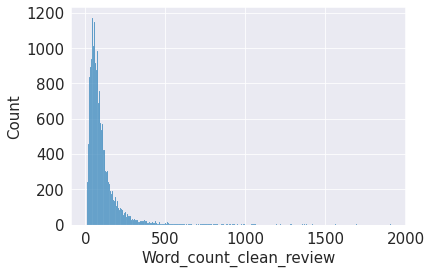

In [18]:
# Number of words in the cleaned Review
df['Word_count_clean_review'] = pd.Series(
    [len(item.split()) for item in df['Cleaned_Review']])

# most of the cleaned review have 20 to 40 words
sns.histplot(df['Word_count_clean_review'])

In [19]:
# finding frequency of all words
all_words = len(clean_review_words)
print('Total words in clean review is {}'.format(all_words))

word_dist = nltk.FreqDist(clean_review_words)

# Creating dataframe for word frequency
freq_data_all = pd.DataFrame(word_dist.most_common(all_words),
                             columns=['Word', 'Frequency'])

# Percentage of word frequency
freq_data_all['percentFreq_all'] = (freq_data_all.Frequency /
                                    freq_data_all.Frequency.sum()) * 100

print('No of unique words {}'.format(len(freq_data_all)))
print(freq_data_all[0:10])

Total words in clean review is 2074365
No of unique words 42847
    Word  Frequency  percentFreq_all
0  hotel      53967         2.601615
1   room      47686         2.298824
2    not      34323         1.654627
3   stay      27981         1.348895
4   good      22057         1.063313
5  great      21616         1.042054
6      n      19112         0.921342
7  staff      16795         0.809645
8  night      14501         0.699057
9    day      13425         0.647186


In [20]:
# words which are used only once 
(freq_data_all['Frequency']==1).value_counts() 

True     21898
False    20949
Name: Frequency, dtype: int64

In [21]:
afn=Afinn()

In [22]:
# Affin Sentiment Score
score = [afn.score(item) for item in df['Cleaned_Review']]

# Positive review = 1
# Negative review = 0

# Affin Sentiment Making it a two class classification problem
Affin_sentiment = [1 if score > 0 else 0 for score in score]

In [23]:
# Affin Sentiment & Score added to the data frame
df['Affin_score'] = score
df['Affin_sentiment'] = Affin_sentiment

In [24]:
# viewing only the negative reviews
df[df['Affin_sentiment'] == 0]['Cleaned_Review']

42       warwick bad good review warwick shock staff qu...
44       austin power decor familiar hotel seattlewhere...
65       hated inn terrible room service horrible staff...
76       stay clear internet reservation friday rang ho...
88       bad hotel experience book nonsmoking room onli...
                               ...                        
20421    bad sleep hip tooooo hip nite club building ca...
20465    not stay hotel bring group february bad hotel ...
20467    return la concha nightmare surprising hotel re...
20484    deceptive staff deceptive desk staff claim not...
20489    hotel theft ruin vacation hotel open sept gues...
Name: Cleaned_Review, Length: 1696, dtype: object

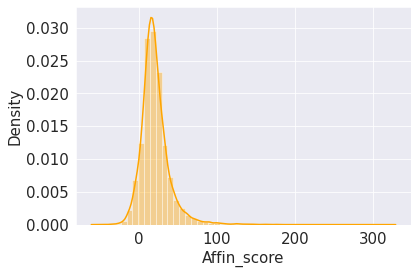

In [25]:
# Affin score visualization
sns.distplot(df['Affin_score'], color='orange')

Class: 1, Number: 18795, Percentage 375.9
Class: 0, Number: 1696, Percentage 33.92


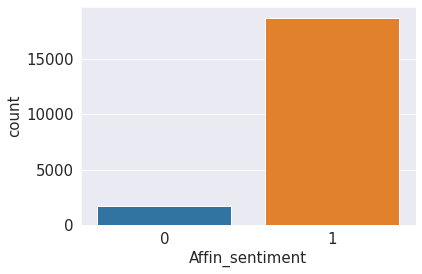

In [26]:
sns.countplot(df['Affin_sentiment'])
counter = Counter(df['Affin_sentiment'])
counter.items()

# Percentage of Data as per Affin Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / 5000 * 100
    print("Class: {}, Number: {}, Percentage {}".format(
        k, v, np.round(per, 2)))

In [27]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(corpus))

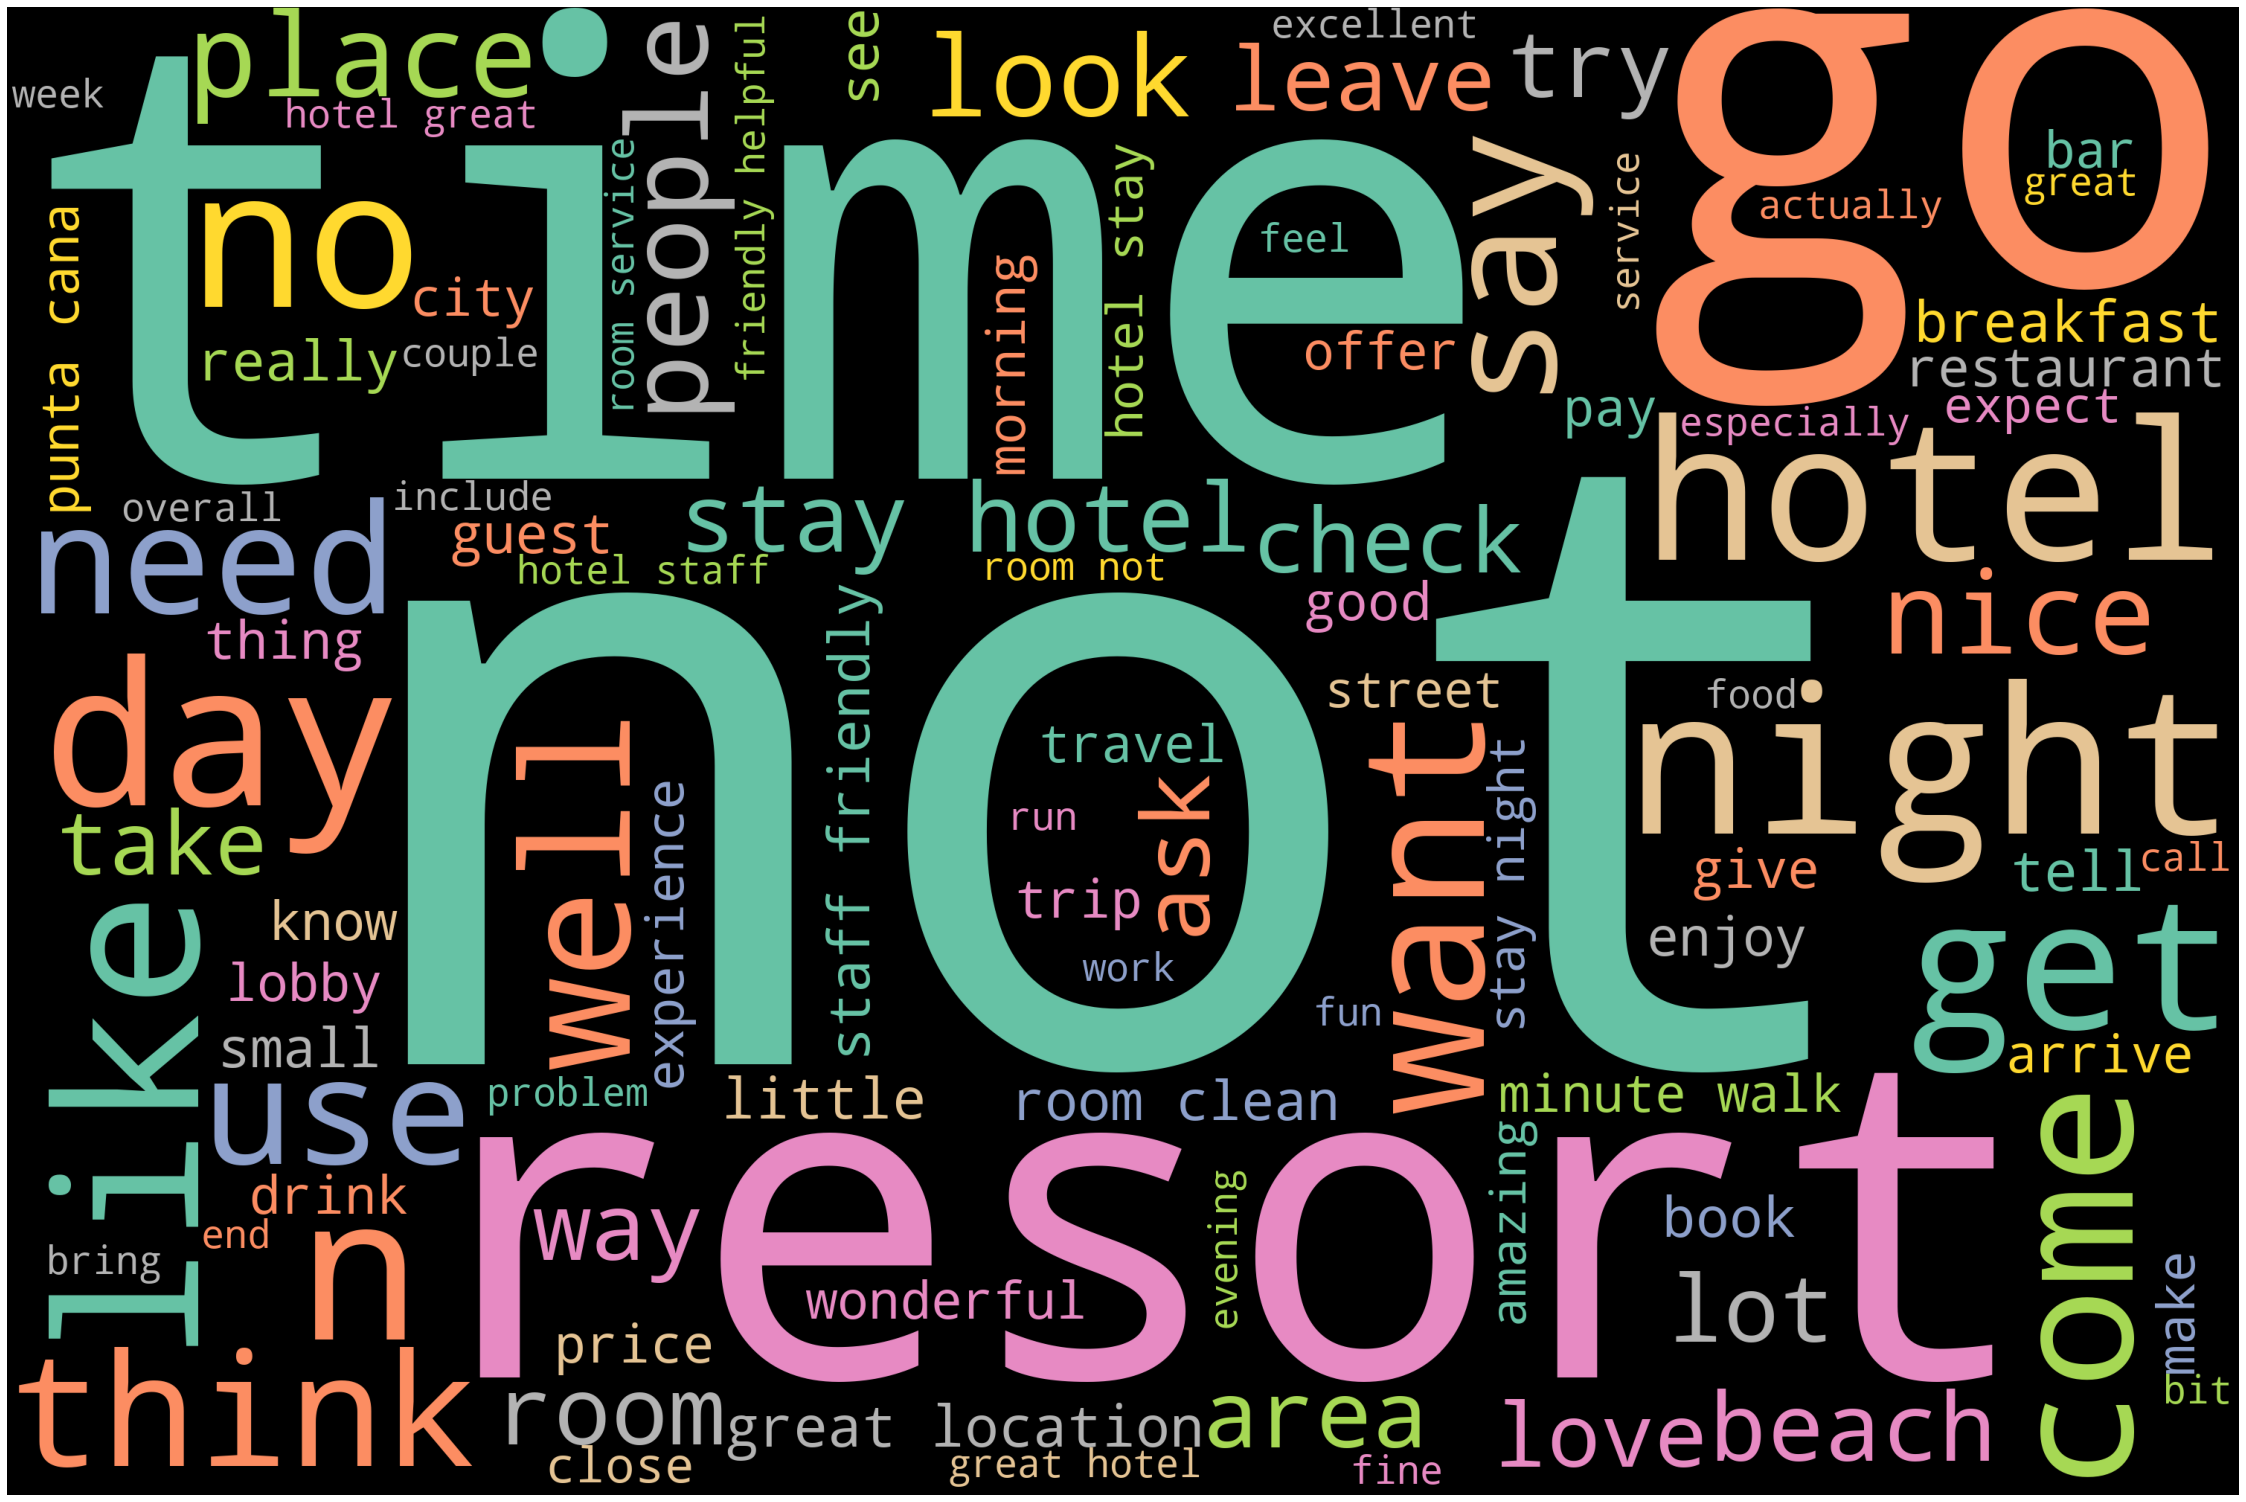

In [28]:
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [29]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(df[df['Affin_sentiment'] == 1]['Cleaned_Review']))

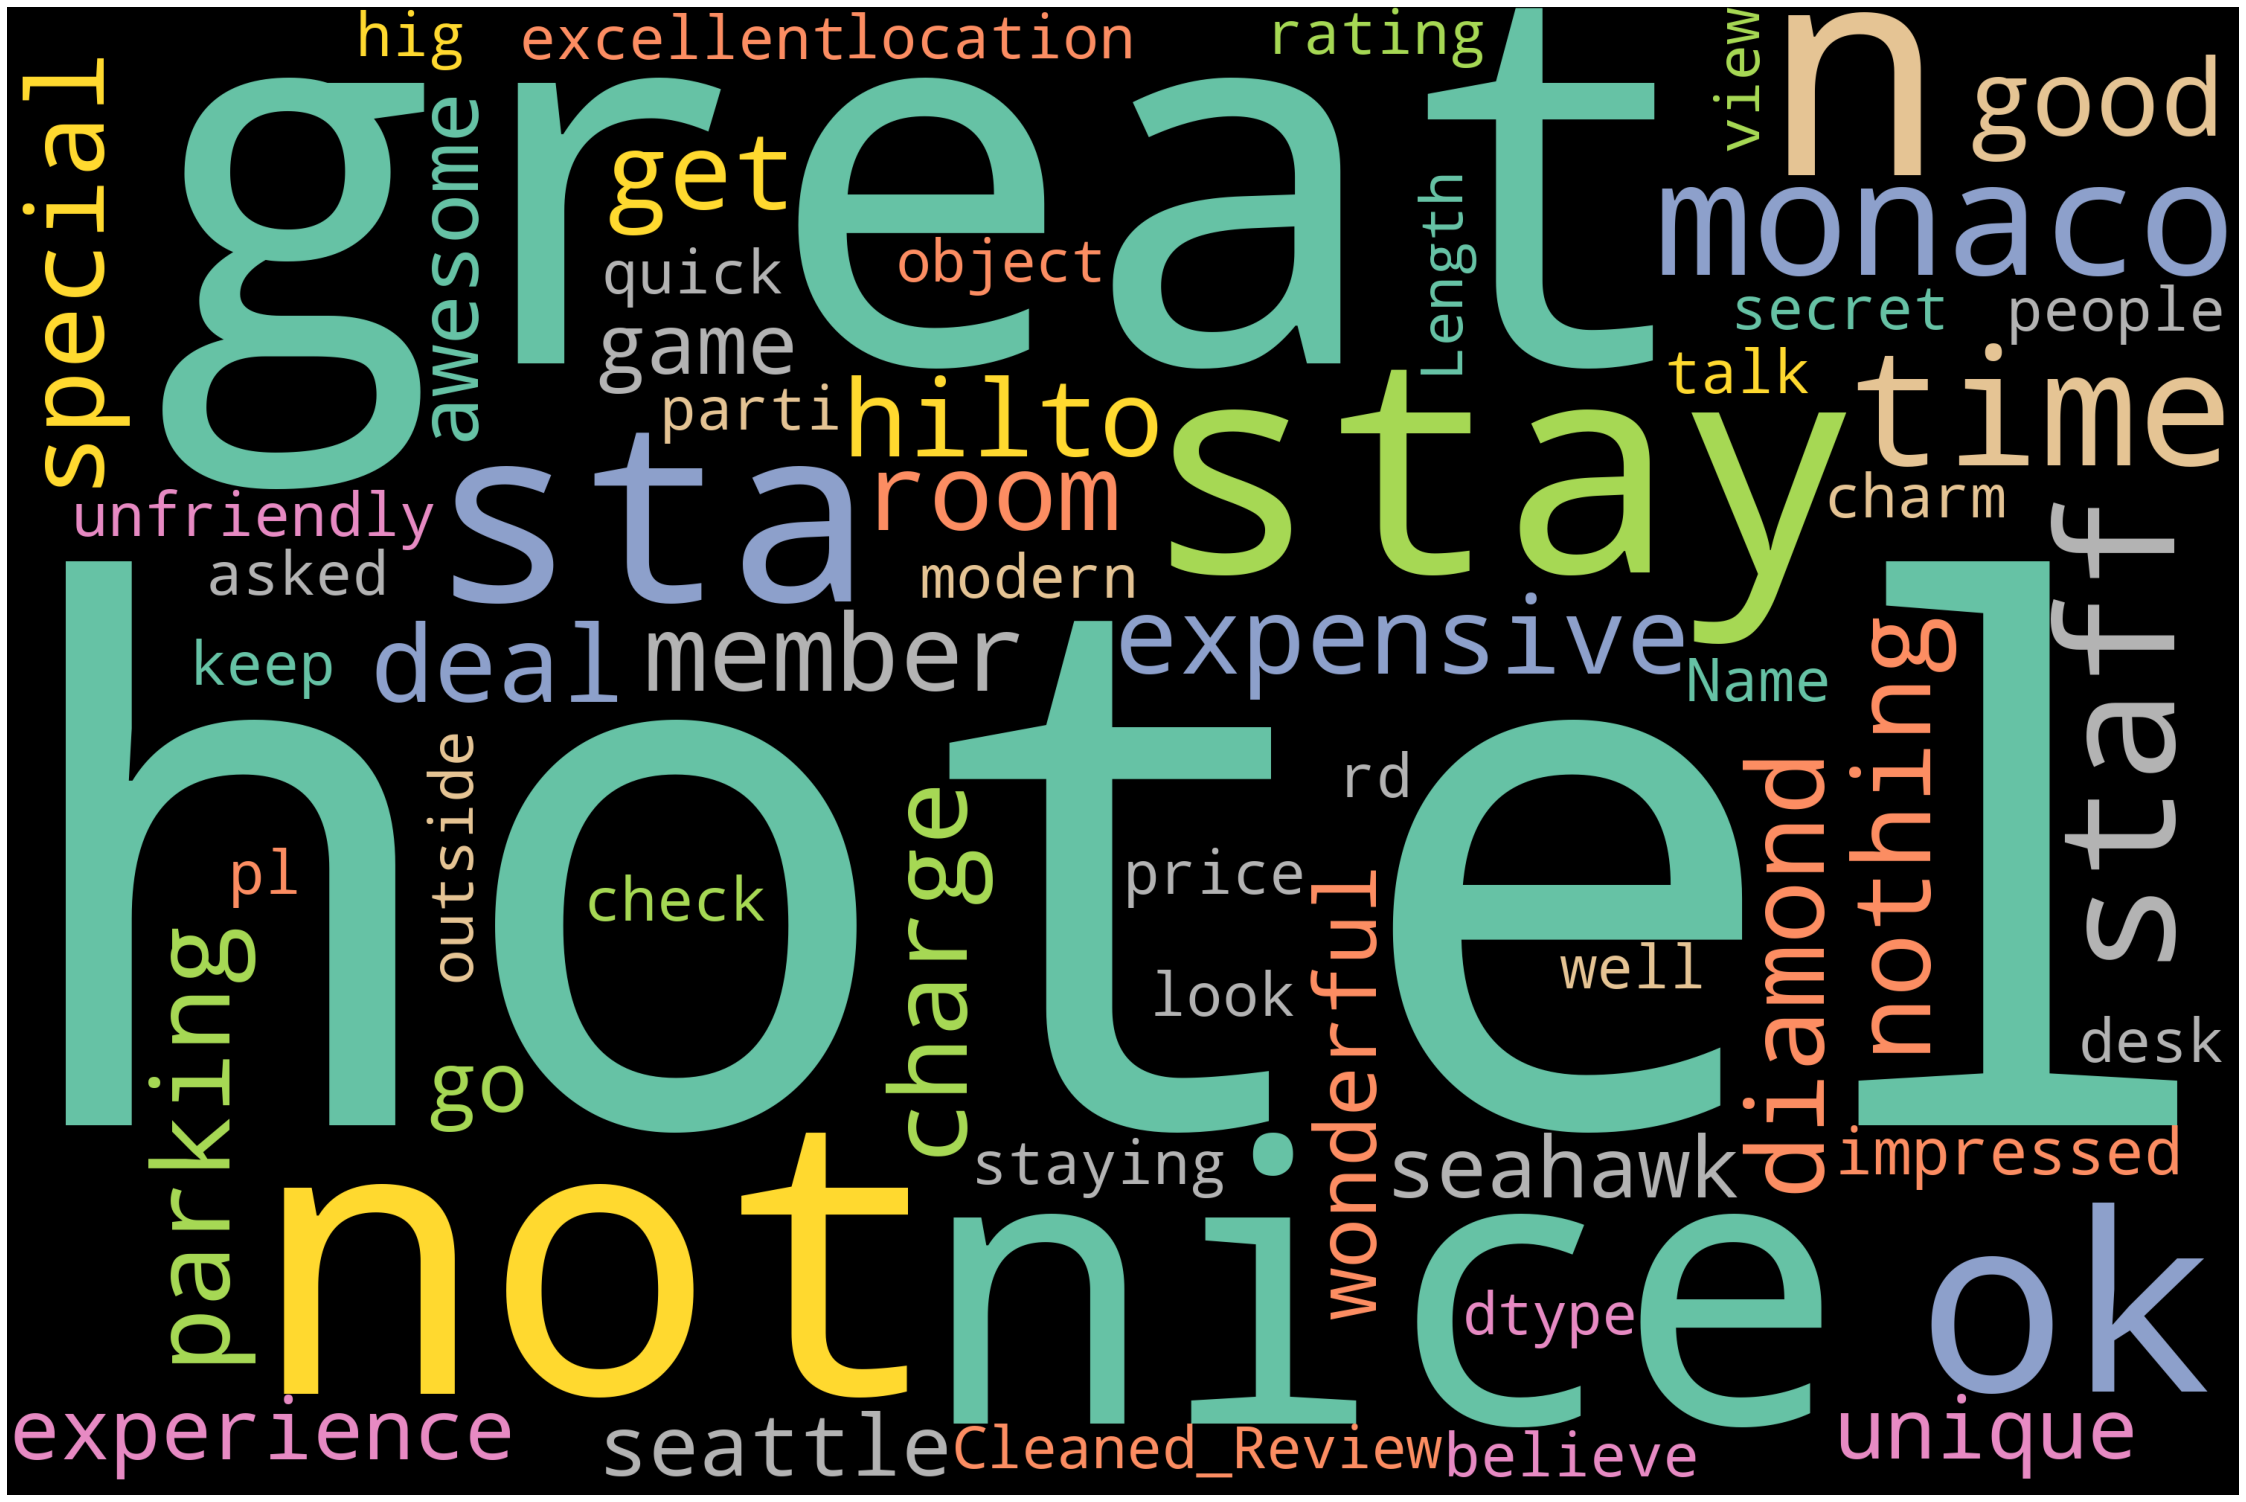

In [30]:
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


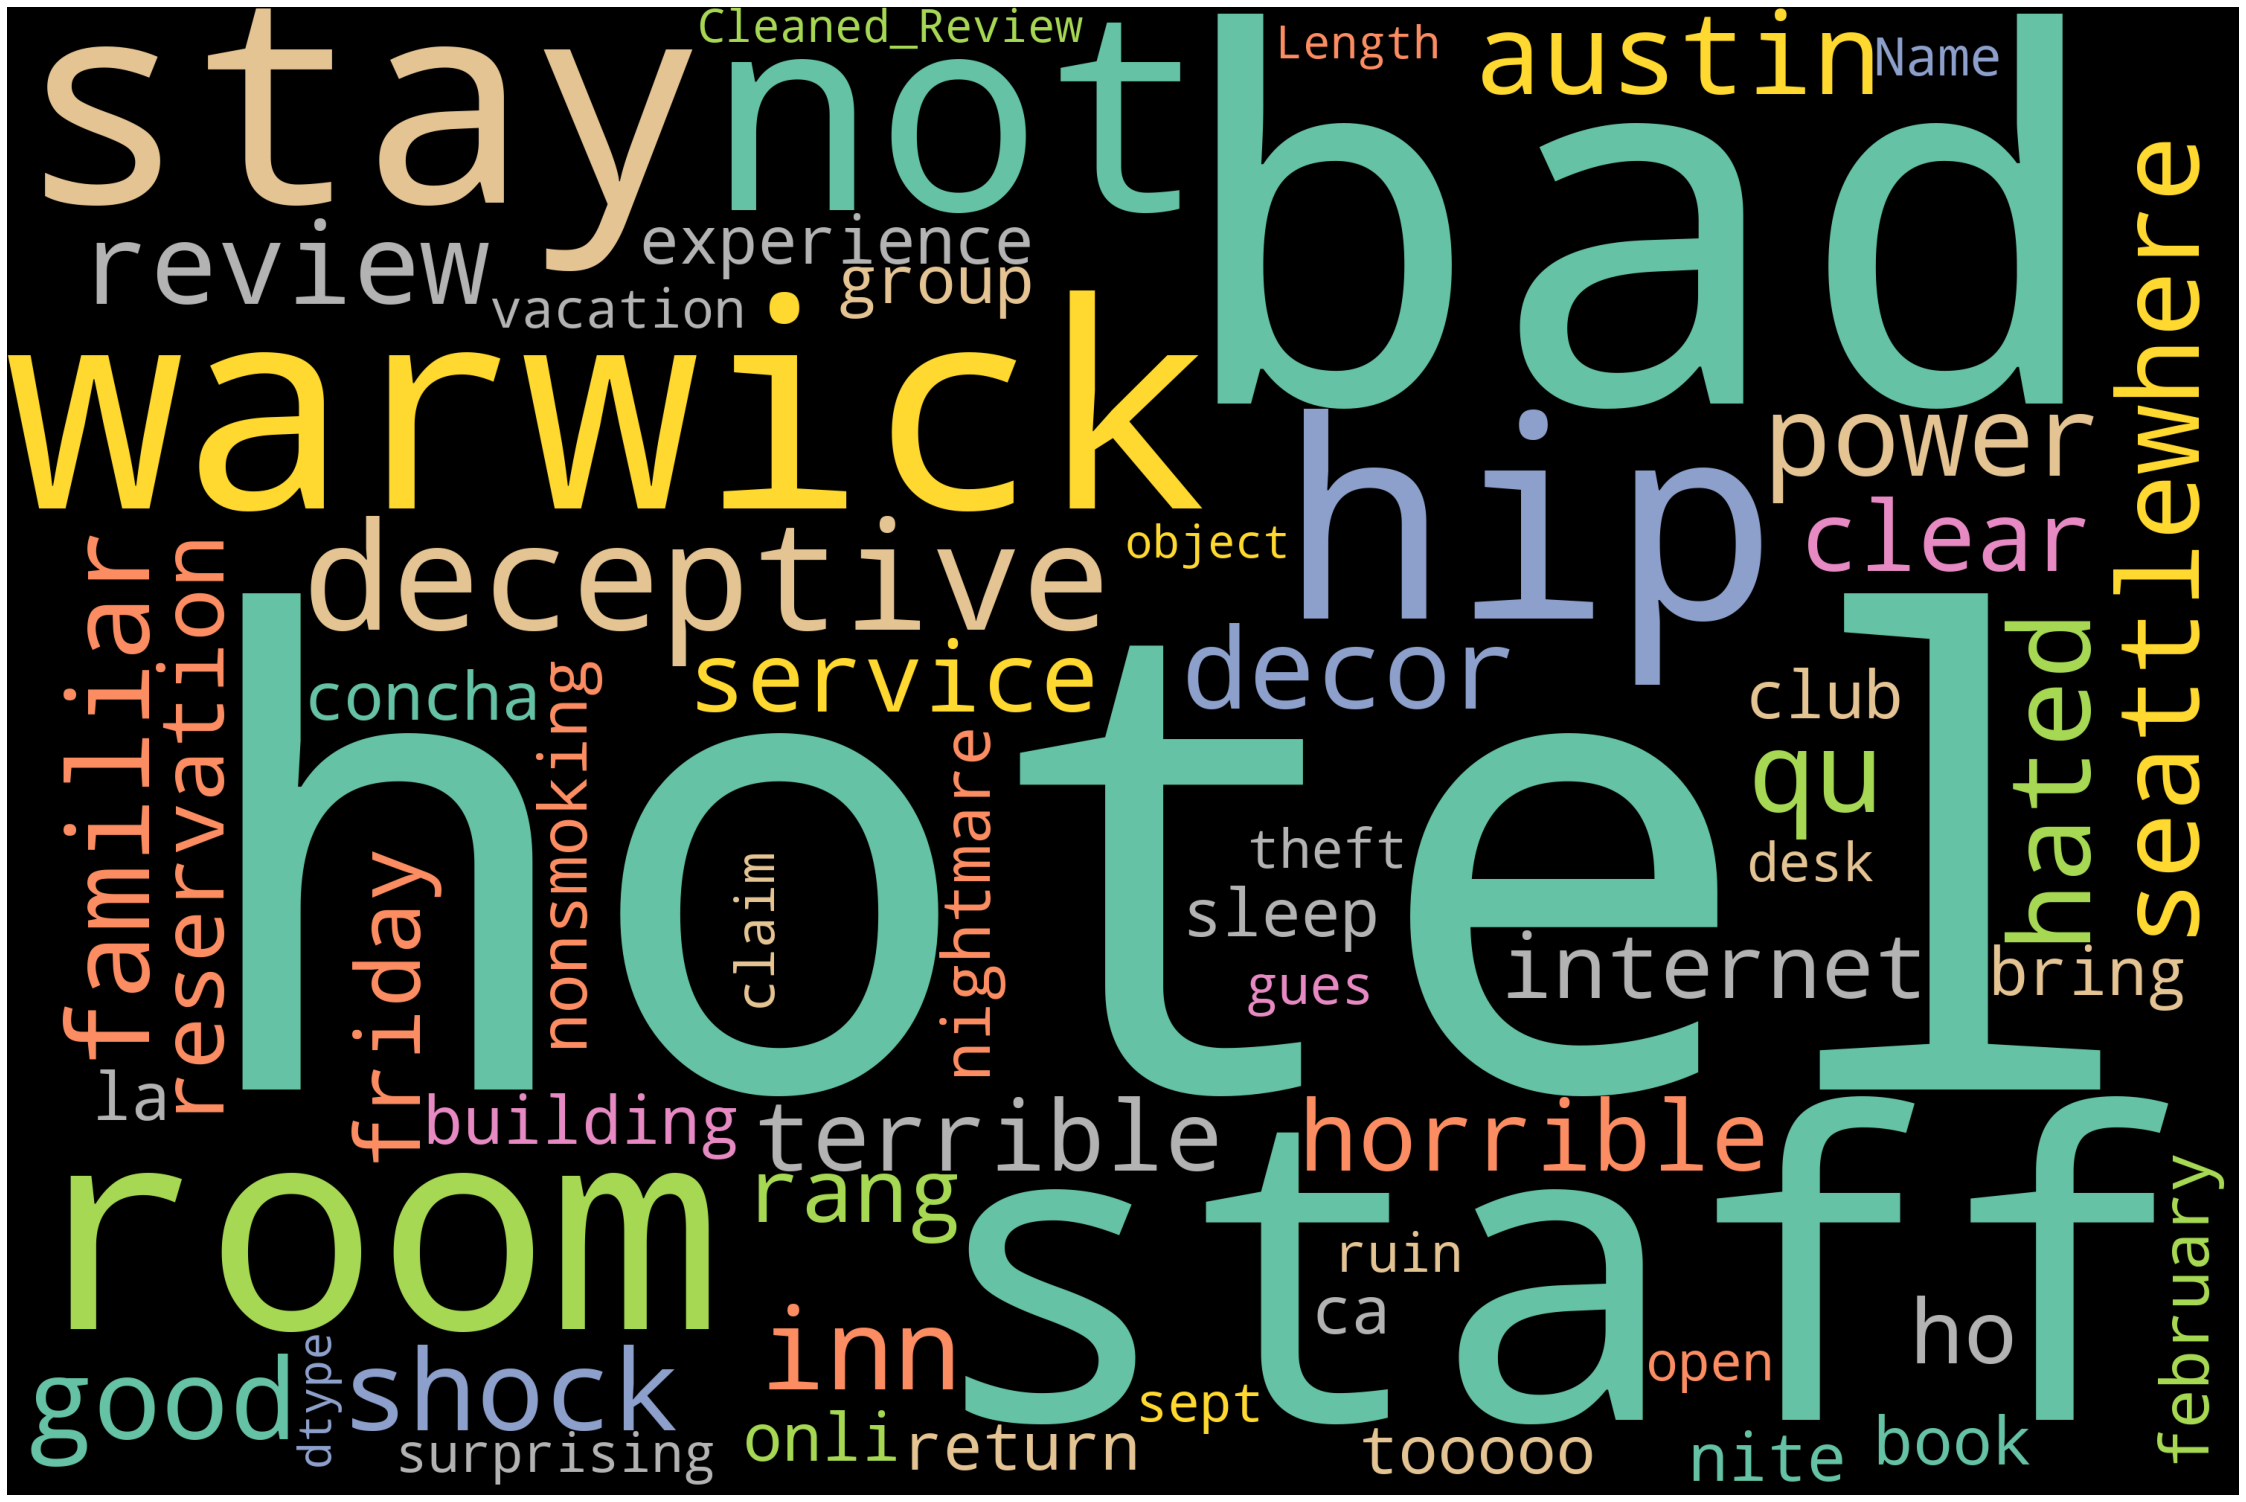

In [31]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(df[df['Affin_sentiment'] == 0]['Cleaned_Review']))
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
# Stop word
stop_words_keywords = stopwords.words('english')

# special additioanl stop words added for keyword extraction
stop_words_keywords.extend([
    "will", "always", "go", "one", "very", "good", "only", "mr", "lot", "two",
    "th", "etc", "don", "due", "didn", "since", "nt", "ms", "ok", "almost",
    "put", "pm", "hyatt", "grand", "till", "add", "let", "hotel", "able",
    "per", "st", "couldn", "yet", "par", "hi", "well", "would", "I", "the",
    "s", "also", "great", "get", "like", "take", "thank"
])

In [33]:
# find the most frequent words in the data, extracting information about its content and topics.

stops = set(stopwords.words('english') + ['com'])
co = CountVectorizer(stop_words=stop_words_keywords)
counts = co.fit_transform(corpus)
most_freq_terms = pd.DataFrame(counts.sum(axis=0),
                               columns=co.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)

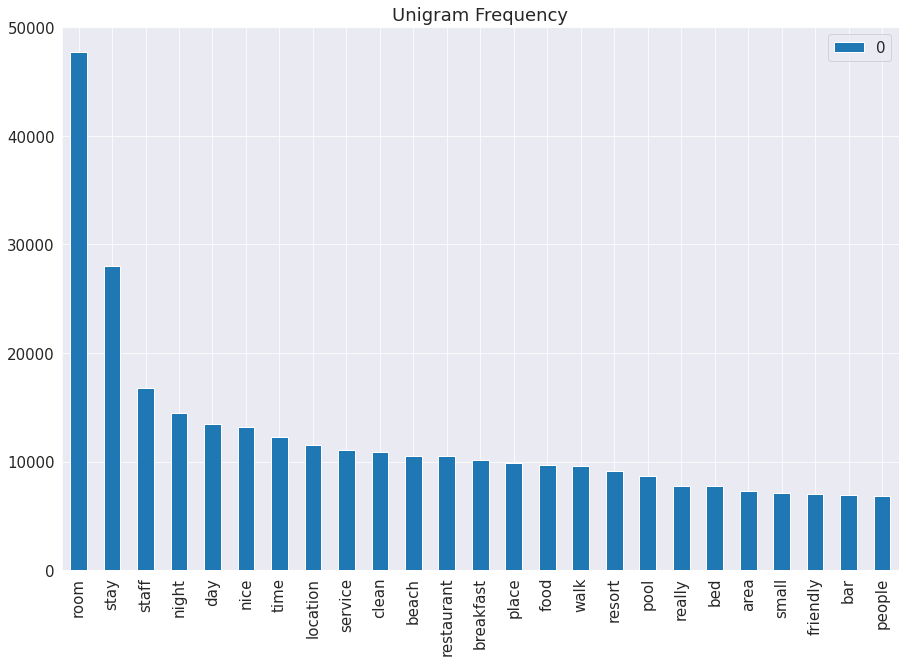

In [34]:
most_freq_terms.plot(kind='bar', title='Unigram Frequency', figsize=(15, 10))

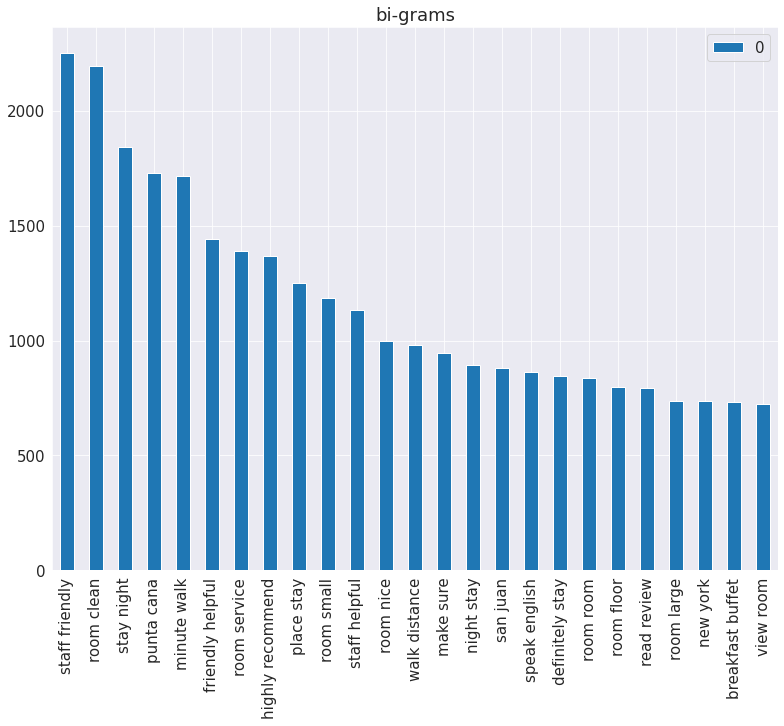

In [35]:
# Now we can check for frequent bi-grams:
co = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
bi_grams = pd.DataFrame(counts1.sum(axis=0),
                        columns=co.get_feature_names()).T.sort_values(
                            0, ascending=False).head(25)
bi_grams.plot(kind='bar', title='bi-grams', figsize=(13, 10))

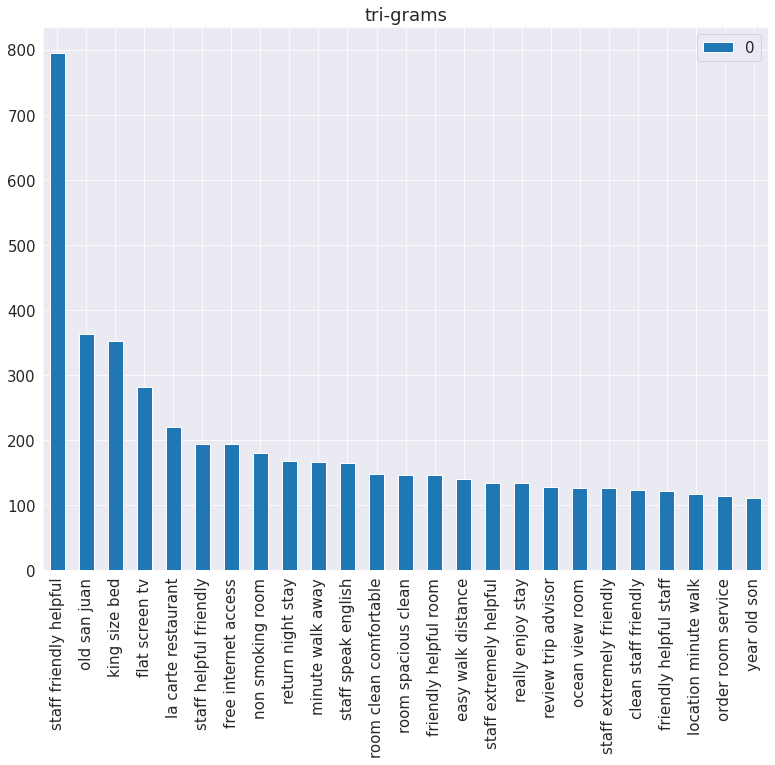

In [36]:
# Now we can check for frequent tri-grams:
co = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
tri_grams = pd.DataFrame(counts1.sum(axis=0),
                         columns=co.get_feature_names()).T.sort_values(
                             0, ascending=False).head(25)
tri_grams.plot(kind='bar', title='tri-grams', figsize=(13, 10))

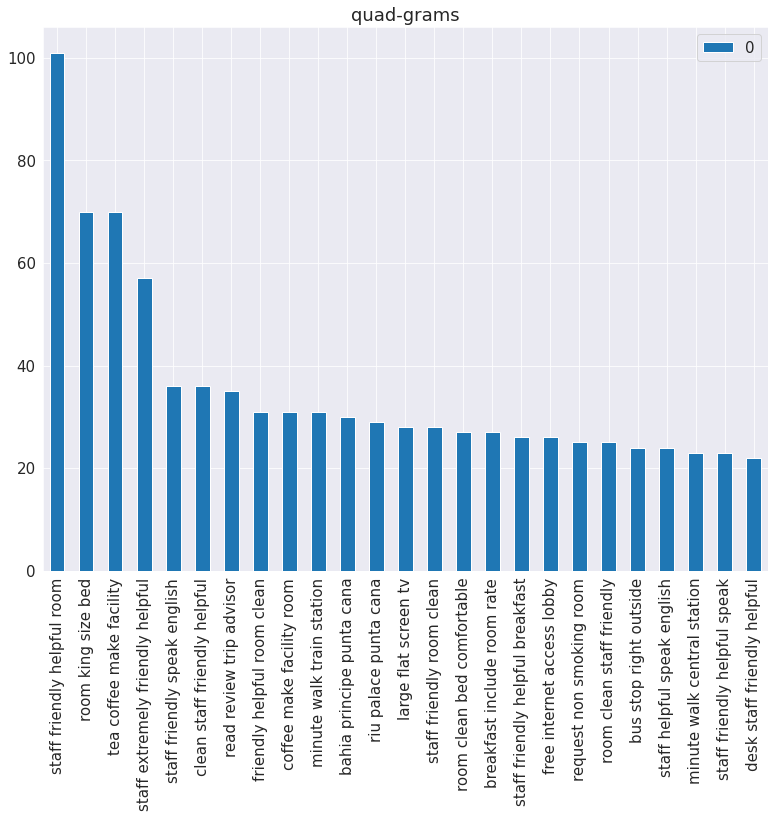

In [37]:
# Now we can check for frequent quad-grams:
co = CountVectorizer(ngram_range=(4, 4), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
tri_grams = pd.DataFrame(counts1.sum(axis=0),
                         columns=co.get_feature_names()).T.sort_values(
                             0, ascending=False).head(25)
tri_grams.plot(kind='bar', title='quad-grams', figsize=(13, 10))

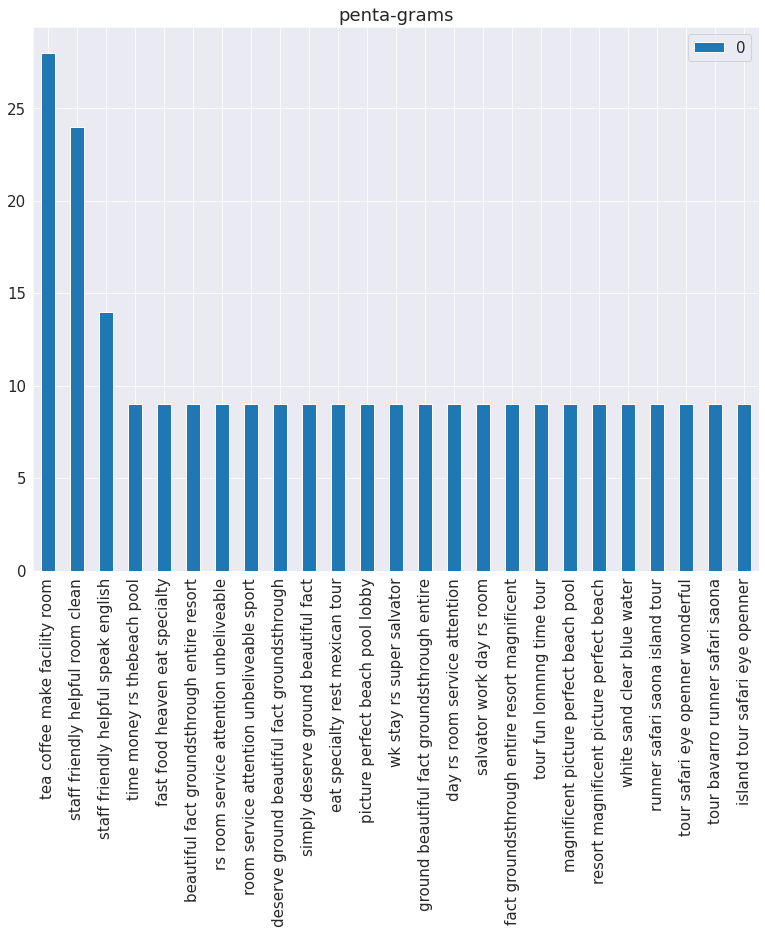

In [38]:
# Now we can check for frequent penta-grams:
co = CountVectorizer(ngram_range=(5, 5), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
tri_grams = pd.DataFrame(counts1.sum(axis=0),
                         columns=co.get_feature_names()).T.sort_values(
                             0, ascending=False).head(25)
tri_grams.plot(kind='bar', title='penta-grams', figsize=(13, 10))

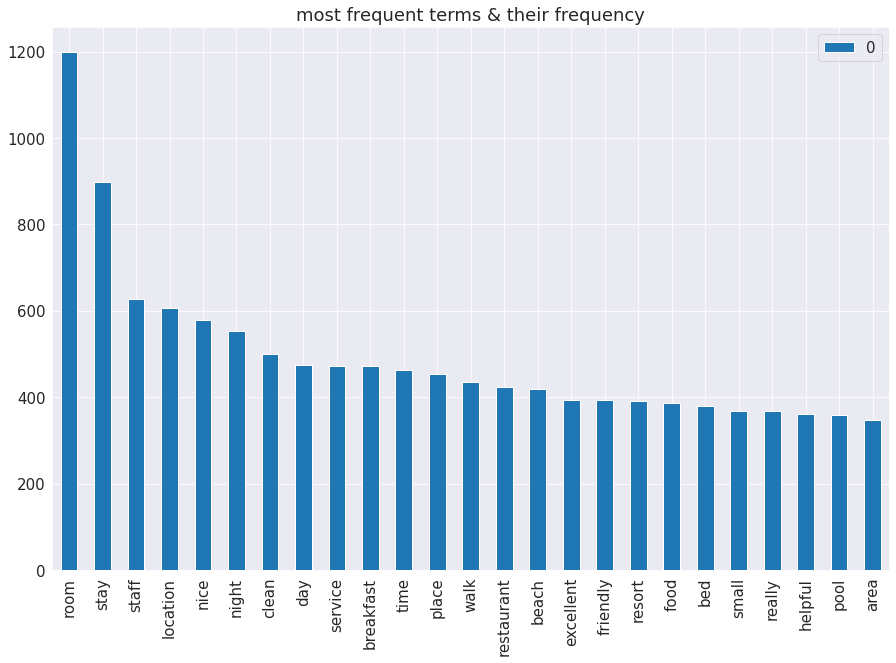

In [39]:
# Converting text into vectors by TFIDF
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,1))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),
                               columns=tfidf2.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)
most_freq_terms.plot(kind='bar',
                     title='most frequent terms & their frequency',
                     figsize=(15, 10))

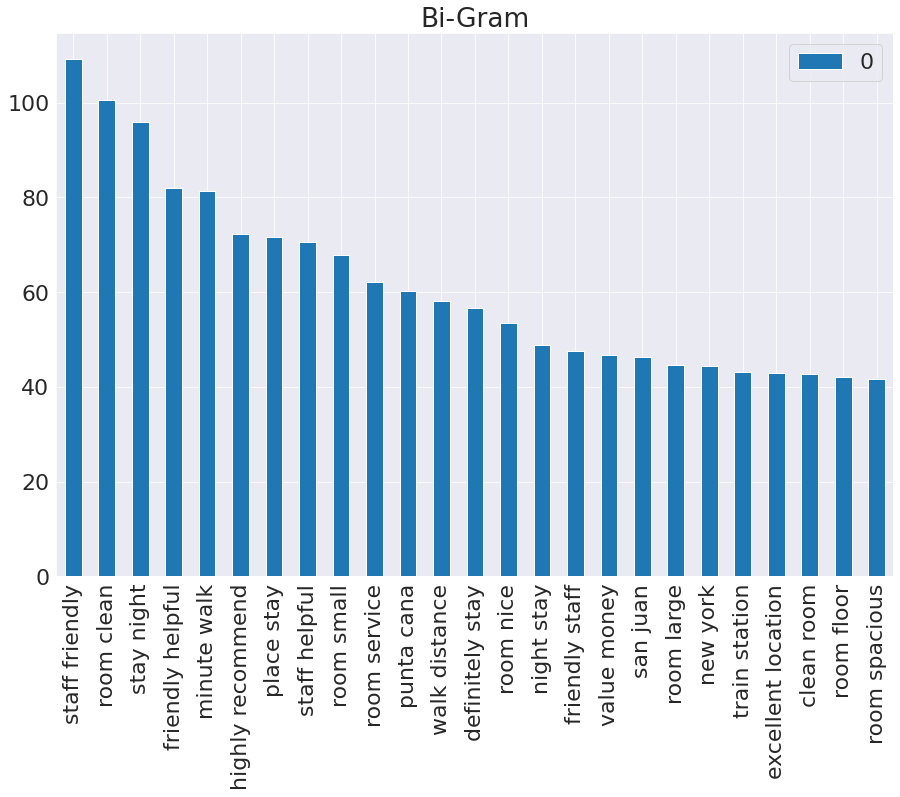

In [40]:
# Now we can check for frequent bi-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(2, 2))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Bi-Gram', figsize=(15, 10))

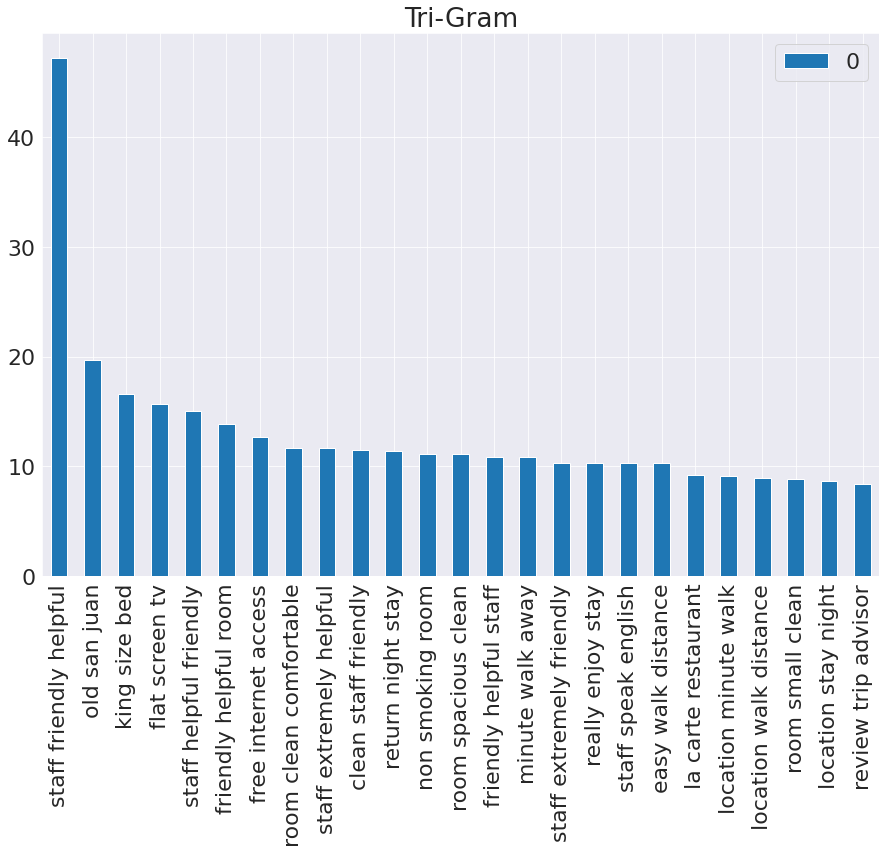

In [41]:
# Now we can check for frequent tri-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(3, 3))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Tri-Gram', figsize=(15, 10))

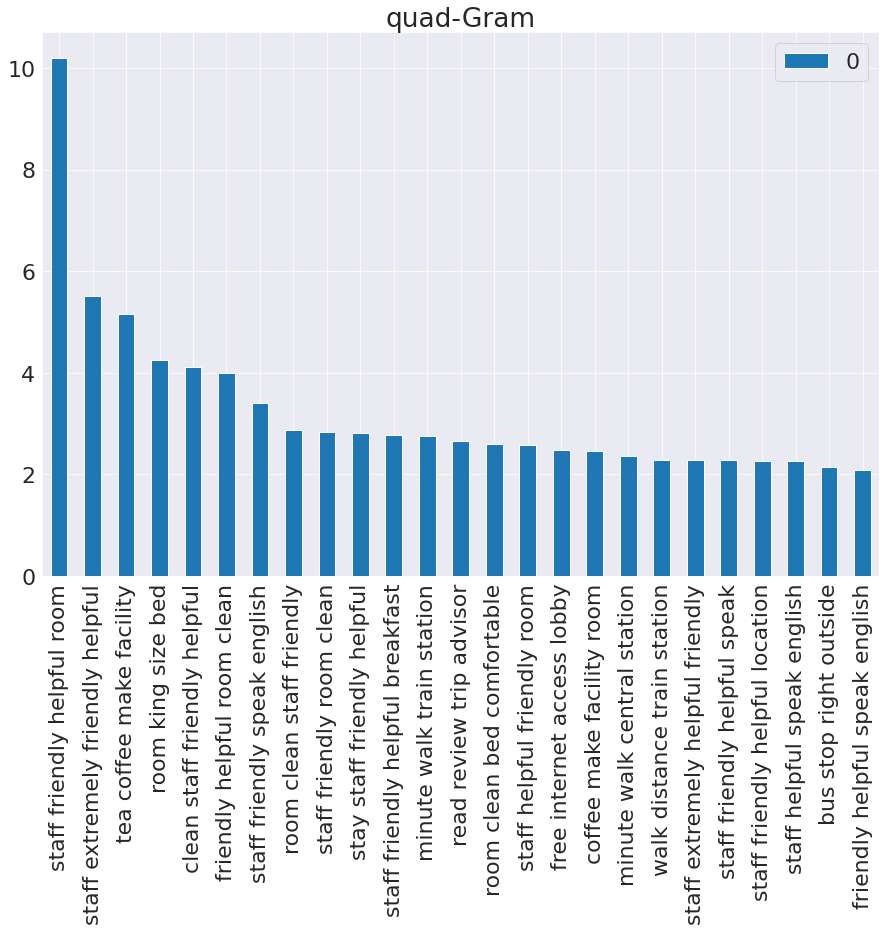

In [42]:
# Now we can check for frequent quad-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(4, 4))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='quad-Gram', figsize=(15, 10))

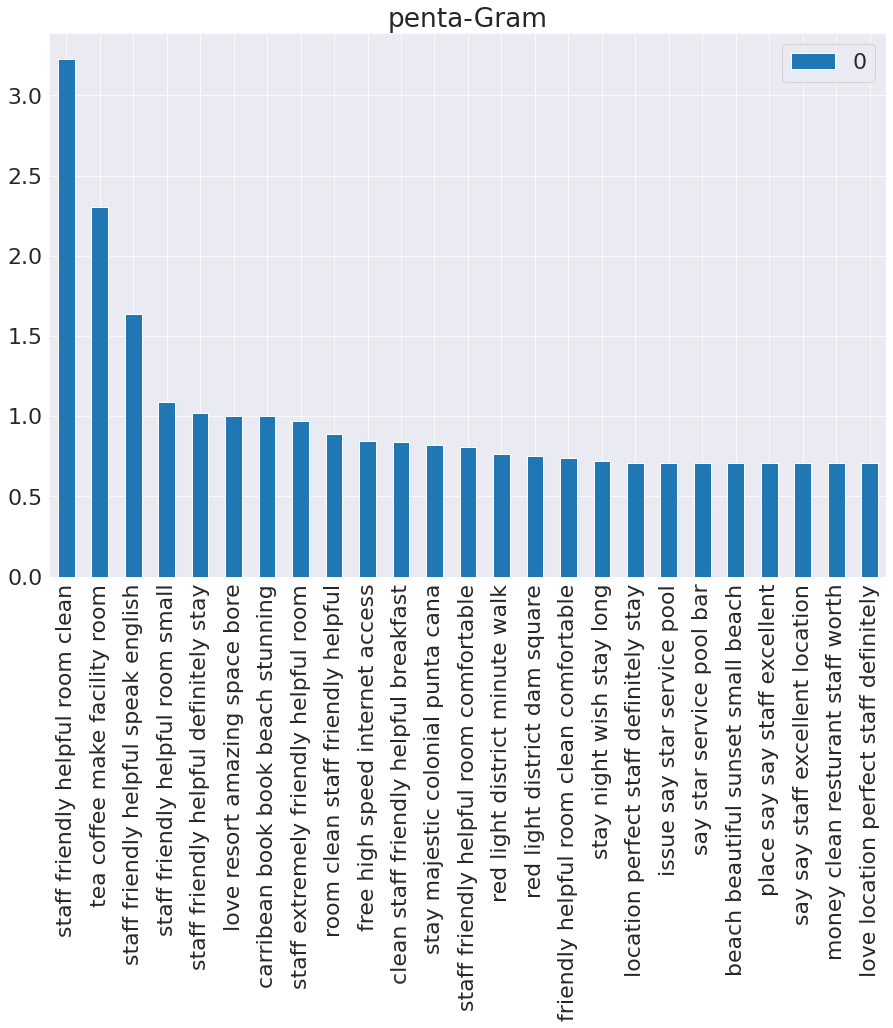

In [43]:
# Now we can check for frequent penta-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(5, 5))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='penta-Gram', figsize=(15, 10))

In [44]:
cv2 = CountVectorizer(stop_words=stop_words_keywords,ngram_range=(1,2))
cv2_x = cv2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(cv2_x)

# get feature names
feature_names = cv2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv2.transform([doc]))

In [45]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
   print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drinking terrece look light city barcelona offer stay go barcelona soccor match amazing definatly worth visit spend day fab tour bus pay e day ticket e day hop bus arounnd city fall love food market ramble main high street get smoothies euro packet fruit euro morning breakfast evening meal usually no dearer e starter main desert look special offer meal display door restaurant total barcelona fab city art buliding history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
barcelona 0.163
fab 0.111
usually dearer 0.1
total barcelona 0.1
terrece look 0.1
street smoothies 0.1
soccor match 0.1
soccor 0.1
smoothies euro 0.1
smoothies 0.1


In [46]:
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,2))
tfidf2_x = tfidf2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(tfidf2_x)

# get feature names
feature_names = tfidf2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(tfidf2.transform([doc]))

In [47]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drinking terrece look light city barcelona offer stay go barcelona soccor match amazing definatly worth visit spend day fab tour bus pay e day ticket e day hop bus arounnd city fall love food market ramble main high street get smoothies euro packet fruit euro morning breakfast evening meal usually no dearer e starter main desert look special offer meal display door restaurant total barcelona fab city art buliding history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
usually dearer 0.117
total barcelona 0.117
terrece look 0.117
street smoothies 0.117
soccor match 0.117
soccor 0.117
smoothies euro 0.117
smoothies 0.117
sand highly 0.117
recocommend 0.117


In [48]:
tfidf = TfidfVectorizer(max_features=3000,
                       ngram_range=(1,3))
# TFIDF for X-train
corpus_tfidf= tfidf.fit_transform(corpus)

# save the model to disk
filename = 'model_TFIDF.sav'
dump(tfidf, open('model_TFIDF.sav', 'wb'))

In [49]:
# Creation of X and Y variable
X = corpus_tfidf
y = df['Affin_sentiment']

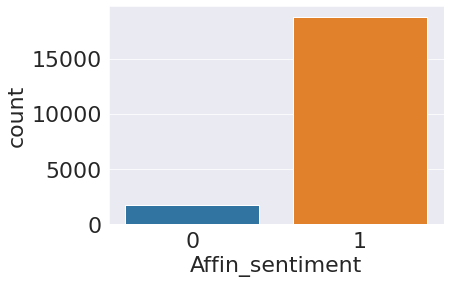

In [50]:
# visualization of the imbalanced Y variable
sns.countplot(y)

In [51]:
# the minority class will over sampled by 80%
stregegy = 0.8

# initializing of SMOTEN Sampling
over = SMOTE(sampling_strategy= stregegy,random_state=7)

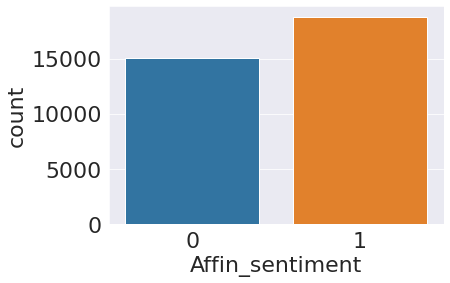

In [52]:
# Over Samplled X and Y variable 
X_over, y_over = over.fit_resample(X, y)
sns.countplot(y_over)

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X_over, y_over,random_state=7,test_size=0.20,stratify=y_over)
print("X_train = {}".format(X_train.shape))
print("X_test = {}".format(X_test.shape))
print("y_train = {}".format(y_train.shape))
print("y_test = {}".format(y_test.shape))

X_train = (27064, 3000)
X_test = (6767, 3000)
y_train = (27064,)
y_test = (6767,)


In [54]:
# custom Fuction to run the model with confusion matrix + Train and test accuracy + F1score
def model_metric(X_train, X_test, y_train, y_test, model, name):

    # predicted for X_train and X_test
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)

    # Accuracy
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)

    # F1score
    f1_score = metrics.f1_score(y_train, predict_train)

    print('Accuracy for Train set {}'.format(accuracy_train))
    print('Accuracy for Test set {}'.format(accuracy_test))
    print('Fi Score {}'.format(f1_score))
    
    print(classification_report(y_test, predict_test))

    plot_confusion_matrix(estimator=model,
                          X=X_test,
                          y_true=y_test,
                          cmap='Blues')
    plt.grid(False)
    plt.title('{} - Confusion Matrix on Test set'.format(name))

In [55]:
# Grid Creation
Grid = dict()
Grid['C'] = (0.001, 0.01, 0.1, 0.18, 0.2, 1,5)
Grid['penalty'] = ("l1", "l2", "elasticnet")

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = LogisticRegression()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'C': 5, 'penalty': 'l2'}
Best Score - 0.976315360805725


Accuracy for Train set 0.9899127992905705
Accuracy for Test set 0.9803457957736073
Fi Score 0.9908484462471926
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3008
           1       1.00      0.97      0.98      3759

    accuracy                           0.98      6767
   macro avg       0.98      0.98      0.98      6767
weighted avg       0.98      0.98      0.98      6767



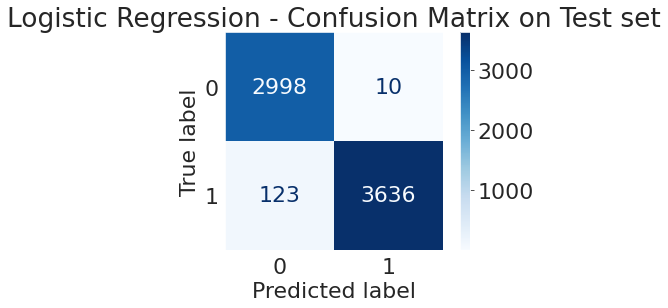

In [56]:
name = 'Logistic Regression'
model_lr = LogisticRegression(C=5, penalty='l2', random_state=7)
model_lr.fit(X_train, y_train)

model_metric(X_train, X_test, y_train, y_test, model_lr,
                'Logistic Regression')

In [57]:
# Grid Creation
Grid = dict()
Grid['n_neighbors'] = range(2,40)

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = KNeighborsClassifier()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'n_neighbors': 3}
Best Score - 0.4731375180251643


Accuracy for Train set 0.5081288796925806
Accuracy for Test set 0.46977981380227574
Fi Score 0.20572792362768497
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      3008
           1       1.00      0.05      0.09      3759

    accuracy                           0.47      6767
   macro avg       0.73      0.52      0.36      6767
weighted avg       0.76      0.47      0.33      6767



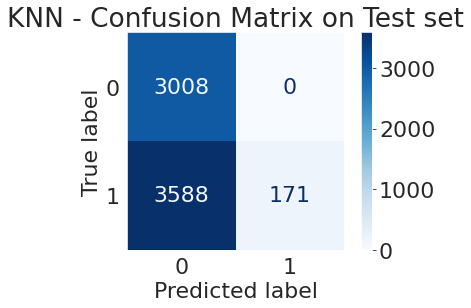

In [58]:
model_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_knn.fit(X_train, y_train)
model_metric(X_train, X_test, y_train, y_test, model_knn, 'KNN')